<h1>>>>>>>Webscraping<<<<<<</h1>

In [187]:
import requests
from bs4 import BeautifulSoup

# URL of the course page
url = 'https://courses.analyticsvidhya.com/courses/creating-problem-solving-agents-using-genai-for-action-composition'

# Send a GET request to the URL
response = requests.get(url)

# Parse the HTML content using BeautifulSoup
soup = BeautifulSoup(response.content, 'html.parser')

# Extract the course title
title = soup.find('h1', class_='section__heading section__heading___28cd9').text.strip()

# Extract the course description
description = soup.find('h2', class_='section__subheading section__subheading___28cd9').text.strip()

# Extract the course curriculum
curriculum_section = soup.find('section', class_='course-curriculum___12deb')
curriculum_header = curriculum_section.find('h3', class_='section__heading').text.strip()

# Extract each curriculum chapter/lesson
curriculum_items = curriculum_section.find_all('li', class_='course-curriculum__chapter')
curriculum = []
for item in curriculum_items:
    chapter_title = item.find('h5', class_='course-curriculum__chapter-title').text.strip()
    lessons = item.find_all('span', class_='course-curriculum__chapter-lesson')
    lesson_titles = [lesson.text.strip() for lesson in lessons]
    curriculum.append({'chapter': chapter_title, 'lessons': lesson_titles})

# Display the results
print("Title of the course:", title)
print("\nCourse Description:", description)
print("\nCourse Curriculum:")
for chapter in curriculum:
    print(f"\n{chapter['chapter']}:")
    for lesson in chapter['lessons']:
        print(f"  - {lesson}")


Title of the course: Creating Problem-Solving Agents using GenAI for Action Composition

Course Description: Discover how Generative AI is revolutionizing Agentic AI systems to solve complex real-world problems.

Course Curriculum:

Creating Problem-Solving Agents using GenAI for Action Composition:
  - Introduction
  - Overview- Count the Number of Agents
  - A brief history of Agentic Systems
  - Agents Today
  - Multi-Agent Systems Today
  - Practical Solutions


<h1>>>>>>Extract the all pages and saving the data into csv<<<<<<</h1>

In [31]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import random
from urllib.parse import urljoin

# Define headers to mimic a browser visit
HEADERS = {
    'User-Agent': (
        'Mozilla/5.0 (Windows NT 10.0; Win64; x64) '
        'AppleWebKit/537.36 (KHTML, like Gecko) '
        'Chrome/58.0.3029.110 Safari/537.3'
    )
}

# Base URL
BASE_URL = 'https://courses.analyticsvidhya.com'

# Main collection URL
MAIN_URL = 'https://courses.analyticsvidhya.com/collections/courses'

# Total number of pages in the main collection
TOTAL_PAGES = 8  # Update this if the number of pages changes

# Function to get all course links from a main collection page
def get_course_links(page_url):
    """
    Extracts all course URLs from a given main collection page.

    Args:
        page_url (str): The URL of the main collection page.

    Returns:
        list: A list of absolute course URLs.
    """
    try:
        response = requests.get(page_url, headers=HEADERS, timeout=10)
        response.raise_for_status()
    except requests.RequestException as e:
        print(f"Error fetching {page_url}: {e}")
        return []

    soup = BeautifulSoup(response.content, 'html.parser')
    course_links = []

    # Adjust the selector based on the actual HTML structure
    for a_tag in soup.find_all('a', href=True):
        href = a_tag['href']
        if '/courses/' in href:  # Change here to include courses
            full_url = urljoin(BASE_URL, href)
            course_links.append(full_url)

    # Remove duplicates by converting to a set
    unique_course_links = list(set(course_links))
    print(f"Found {len(unique_course_links)} courses on {page_url}")
    return unique_course_links

# Function to scrape course details from a course page
def scrape_course_details(course_url):
    """
    Scrapes the course title, description, and curriculum from a course page.

    Args:
        course_url (str): The URL of the course page.

    Returns:
        dict: A dictionary containing the course details.
    """
    try:
        response = requests.get(course_url, headers=HEADERS, timeout=10)
        response.raise_for_status()
    except requests.RequestException as e:
        print(f"Error fetching {course_url}: {e}")
        return None

    soup = BeautifulSoup(response.content, 'html.parser')

    # Extract the course title using partial class matching
    title_tag = soup.find('h1', class_=lambda x: x and 'section__heading' in x)
    title = title_tag.text.strip() if title_tag else 'N/A'
    
    # Extract the course description using partial class matching
    description_tag = soup.find('h2', class_=lambda x: x and 'section__subheading' in x)
    description = description_tag.text.strip() if description_tag else 'N/A'
    
    # Extract the course curriculum using partial class matching
    curriculum_section = soup.find('section', class_=lambda x: x and 'course-curriculum' in x)
    course_curriculum = ''

    if curriculum_section:
        curriculum_items = curriculum_section.find_all('li', class_=lambda x: x and 'course-curriculum__chapter' in x)
        curriculum_lines = []
        for item in curriculum_items:
            chapter_title_tag = item.find('h5', class_=lambda x: x and 'course-curriculum__chapter-title' in x)
            chapter_title = chapter_title_tag.text.strip() if chapter_title_tag else 'N/A'
            curriculum_lines.append(chapter_title)

            lessons = item.find_all('span', class_=lambda x: x and 'course-curriculum__chapter-lesson' in x)
            for lesson in lessons:
                lesson_title = lesson.text.strip()
                curriculum_lines.append(f"  - {lesson_title}")

        course_curriculum = '\n'.join(curriculum_lines)
    else:
        course_curriculum = 'N/A'

    if title == 'N/A' and description == 'N/A' and course_curriculum == 'N/A':
        print(f"Skipping course due to missing all details: {course_url}")
        return None

    print(f"Scraped course: {title}")
    return {
        'Course Title': title,
        'Course Description': description,
        'Course Curriculum': course_curriculum,
        'Course URL': course_url  # Optional: Include course URL for reference
    }

# Main function to orchestrate scraping
def main():
    all_courses = []

    for page_num in range(1, TOTAL_PAGES + 1):
        # Construct the URL for each page
        if page_num == 1:
            page_url = MAIN_URL
        else:
            page_url = f"{MAIN_URL}?page={page_num}"

        print(f"\nProcessing main page {page_num}: {page_url}")
        course_links = get_course_links(page_url)

        for course_url in course_links:
            course_data = scrape_course_details(course_url)
            if course_data:
                all_courses.append(course_data)

            # Optional: Add a random delay to be polite to the server
            time.sleep(random.uniform(1, 3))

        # Optional: Add a longer delay between main pages
        time.sleep(random.uniform(5, 10))

    if not all_courses:
        print("No course data was scraped. Please check the selectors and try again.")
        return

    # Create a DataFrame from the collected data
    df = pd.DataFrame(all_courses)

    # Define CSV file name
    csv_file = 'all_courses_data.csv'

    # Export DataFrame to CSV
    df.to_csv(csv_file, index=False, encoding='utf-8')

    print(f"\nAll data has been successfully saved to {csv_file}")

if __name__ == "__main__":
    main()



Processing main page 1: https://courses.analyticsvidhya.com/collections/courses
Found 9 courses on https://courses.analyticsvidhya.com/collections/courses
Scraped course: Creating Problem-Solving Agents using GenAI for Action Composition
Scraped course: Building Smarter LLMs with Mamba and State Space Model
Scraped course: Improving Real World RAG Systems: Key Challenges & Practical Solutions
Scraped course: Building LLM Applications using Prompt Engineering - Free Course
Scraped course: Generative AI - A Way of Life - Free Course
Scraped course: Bagging and Boosting ML Algorithms - Free Course
Scraped course: MidJourney: From Inspiration to Implementation - Free Course
Scraped course: Building Your First Computer Vision Model - Free Course
Scraped course: Framework to Choose the Right LLM for your Business

Processing main page 2: https://courses.analyticsvidhya.com/collections/courses?page=2
Found 9 courses on https://courses.analyticsvidhya.com/collections/courses?page=2
Scraped co

<h1>>>>>Data Preprocessing<<<<<</h1>

In [2]:
#Importng the pacakges
import numpy as np
import pandas as pd

In [3]:
#Read the dataset csv file
df=pd.read_csv("all_courses_data.csv")

In [4]:
#Reading file displaying
df

,Course Title,Course Description,Course Curriculum,Course URL
0,Creating Problem-Solving Agents using GenAI fo...,Discover how Generative AI is revolutionizing ...,Creating Problem-Solving Agents using GenAI fo...,https://courses.analyticsvidhya.com/courses/cr...
1,Building Smarter LLMs with Mamba and State Spa...,Master Mamba's selective state space model for...,Course Overview\n - Course Overview\nAn Alter...,https://courses.analyticsvidhya.com/courses/bu...
2,Improving Real World RAG Systems: Key Challeng...,Master key challenges in real-world Retrieval-...,Improving Real World RAG System\n - Introduct...,https://courses.analyticsvidhya.com/courses/im...
3,Building LLM Applications using Prompt Enginee...,This free course offers a comprehensive guide ...,How to build diffferent LLM AppIications?\n -...,https://courses.analyticsvidhya.com/courses/bu...
4,Generative AI - A Way of Life - Free Course,Embark on a journey into Generative AI for beg...,Introduction to Generative AI\n - Fundamental...,https://courses.analyticsvidhya.com/courses/ge...
5,Bagging and Boosting ML Algorithms - Free Course,This free course on Advanced ML Algorithms - B...,Bagging\n - Resources to be used in this cour...,https://courses.analyticsvidhya.com/courses/ba...
6,MidJourney: From Inspiration to Implementation...,Understand the fundamentals of the famous imag...,MidJourney\n - MidJourney - Storm _ Story\n ...,https://courses.analyticsvidhya.com/courses/mi...
7,Building Your First Computer Vision Model - Fr...,Embarking on a career in Computer Vision can b...,Introduction to Computer Vision\n - Pixel Per...,https://courses.analyticsvidhya.com/courses/bu...
8,Framework to Choose the Right LLM for your Bus...,This course provides a comprehensive framework...,Introduction\n - Introduction\nIt's an LLM Wo...,https://courses.analyticsvidhya.com/courses/ch...
9,The A to Z of Unsupervised ML - Free Course,Get ahead of the crowd with this free course o...,Understanding Unsupervised Machine Learning\n ...,https://courses.analyticsvidhya.com/courses/fr...


In [5]:
#Tell the datatype,how many columns and rows have and also there is null values have or not 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Course Title        59 non-null     object
 1   Course Description  58 non-null     object
 2   Course Curriculum   59 non-null     object
 3   Course URL          59 non-null     object
dtypes: object(4)
memory usage: 2.0+ KB


In [6]:
#Null valuess checking
df.isnull().sum()

Course Title          0
Course Description    1
Course Curriculum     0
Course URL            0
dtype: int64

In [7]:
#Duplicated values checking
df.duplicated()

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28    False
29    False
30    False
31    False
32    False
33    False
34    False
35    False
36    False
37    False
38    False
39    False
40    False
41    False
42    False
43    False
44    False
45    False
46    False
47    False
48    False
49    False
50    False
51    False
52    False
53    False
54    False
55    False
56    False
57    False
58    False
dtype: bool

In [8]:
#Null value where have in the dataset any
df[df.isnull().any(axis=1)]

,Course Title,Course Description,Course Curriculum,Course URL
22,AI Ethics by Fractal,NaN,AI Ethics\n - FREE PREVIEW\n - Fractal's Eth...,https://courses.analyticsvidhya.com/courses/ai...


<h3>22 row course description have the nan data </h3>

In [9]:
#Filling the nan to value 
# Assuming df is your DataFrame
df.loc[df['Course Title'] == 'AI Ethics by Fractal', 'Course Description'] = 'AI has a huge influence on our lives. From typing on our smartphones, to personalized recommendations on our favourite shopping websites, intelligent machines are everywhere. Our interactions with technology have become more personalized, but with humans ultimately behind these creations, the question is: where does the responsibility lie? Why and how should we begin the AI ethics conversation at Fractal?'

# Check if the value was replaced
print(df[df['Course Title'] == 'AI Ethics by Fractal'])


            Course Title                                 Course Description  \
22  AI Ethics by Fractal  AI has a huge influence on our lives. From typ...   

                                    Course Curriculum  \
22  AI Ethics\n  - FREE PREVIEW\n  - Fractal's Eth...   

                                           Course URL  
22  https://courses.analyticsvidhya.com/courses/ai...  


In [10]:
df.isnull().sum()

Course Title          0
Course Description    0
Course Curriculum     0
Course URL            0
dtype: int64

In [11]:
df.tail(40)

,Course Title,Course Description,Course Curriculum,Course URL
19,Nano Course: Dreambooth-Stable Diffusion for C...,Theory to Practice: Dive into Stable Diffusion...,Dreambooth-Stable Diffusion for Custom Images\...,https://courses.analyticsvidhya.com/courses/na...
20,Machine Learning Summer Training,"In this free Machine Learning Summer Training,...",Overview of the Course\n - FREE PREVIEW\n - ...,https://courses.analyticsvidhya.com/courses/ma...
21,A Comprehensive Learning Path to Become a Data...,"Want to become a data engineer this year, but ...",Overview of Learning Path 2022\n - Overview o...,https://courses.analyticsvidhya.com/courses/a-...
22,AI Ethics by Fractal,AI has a huge influence on our lives. From typ...,AI Ethics\n - FREE PREVIEW\n - Fractal's Eth...,https://courses.analyticsvidhya.com/courses/ai...
23,Nano Course: Building Large Language Models fo...,Learn how to train Large Language Models for C...,Building Large Language Models for Code\n - I...,https://courses.analyticsvidhya.com/courses/bu...
24,A Comprehensive Learning Path to Become a Data...,"Want to become a data scientist this year, but...",Overview of the Learning Path 2024\n - Overvi...,https://courses.analyticsvidhya.com/courses/a-...
25,Top Data Science Projects for Analysts and Dat...,Kick-start your career in data science with ou...,Welcome to the course!\n - About the Data Sci...,https://courses.analyticsvidhya.com/courses/to...
26,Writing Powerful Data Science Articles,Are you looking to write and publish your data...,Welcome to the Data Science Writing Crash Cour...,https://courses.analyticsvidhya.com/courses/wr...
27,Ace Data Science Interviews,A comprehensive course covering different kind...,Overview - Ace Data Science Interviews\n - FR...,https://courses.analyticsvidhya.com/courses/ac...
28,Applied Machine Learning - Beginner to Profess...,This course provides you all the tools and tec...,Introduction to Data Science and Machine Learn...,https://courses.analyticsvidhya.com/courses/ap...


In [12]:
#copy the data set into new variabel
Free=df.copy()

In [13]:
df.head()

,Course Title,Course Description,Course Curriculum,Course URL
0,Creating Problem-Solving Agents using GenAI fo...,Discover how Generative AI is revolutionizing ...,Creating Problem-Solving Agents using GenAI fo...,https://courses.analyticsvidhya.com/courses/cr...
1,Building Smarter LLMs with Mamba and State Spa...,Master Mamba's selective state space model for...,Course Overview\n - Course Overview\nAn Alter...,https://courses.analyticsvidhya.com/courses/bu...
2,Improving Real World RAG Systems: Key Challeng...,Master key challenges in real-world Retrieval-...,Improving Real World RAG System\n - Introduct...,https://courses.analyticsvidhya.com/courses/im...
3,Building LLM Applications using Prompt Enginee...,This free course offers a comprehensive guide ...,How to build diffferent LLM AppIications?\n -...,https://courses.analyticsvidhya.com/courses/bu...
4,Generative AI - A Way of Life - Free Course,Embark on a journey into Generative AI for beg...,Introduction to Generative AI\n - Fundamental...,https://courses.analyticsvidhya.com/courses/ge...


<h1>>>>>Model building<<<<</h1>

<h3>Total dataset have the catergorical data i applying the NLP techinque pfor this process Preprocessing and Tokenization</h3>

In [14]:
import re
import pickle
import numpy as np
import pandas as pd

# Function to clean text
def clean_text(text):
    if isinstance(text, str):
        # Remove special characters and numbers
        text = re.sub(r'[^A-Za-z\s]', '', text)
        # Convert to lowercase
        text = text.lower()
        # Remove extra spaces
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    return ''
# Apply cleaning to relevant columns
df['Course Title Clean'] = df['Course Title'].apply(clean_text)
df['Course Description Clean'] = df['Course Description'].apply(clean_text)
df['Course Curriculum Clean'] = df['Course Curriculum'].apply(clean_text)

# Combine all cleaned text into a single column for embedding
df['Combined Text'] = df['Course Title Clean'] + ' ' + df['Course Description Clean'] + ' ' + df['Course Curriculum Clean']


In [15]:
df['Combined Text'].head()

0    creating problemsolving agents using genai for...
1    building smarter llms with mamba and state spa...
2    improving real world rag systems key challenge...
3    building llm applications using prompt enginee...
4    generative ai a way of life free course embark...
Name: Combined Text, dtype: object

In [16]:
pip install WordCloud

Note: you may need to restart the kernel to use updated packages.


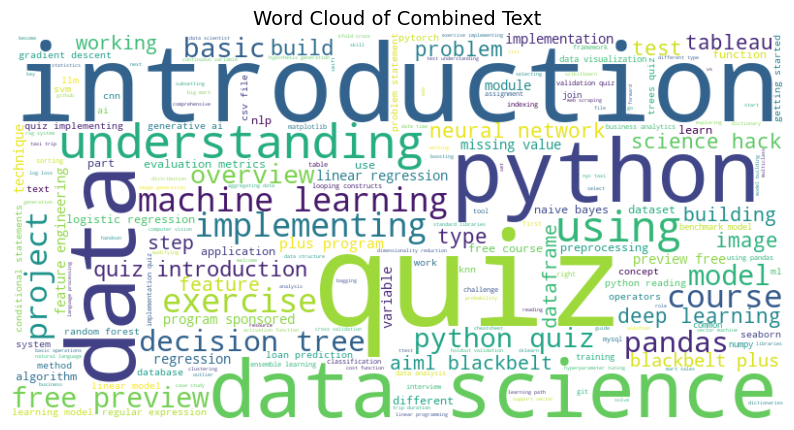

In [19]:
# 1. Word Cloud Visualization
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

text_combined = ' '.join(df['Combined Text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_combined)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Combined Text', fontsize=14)
plt.show()


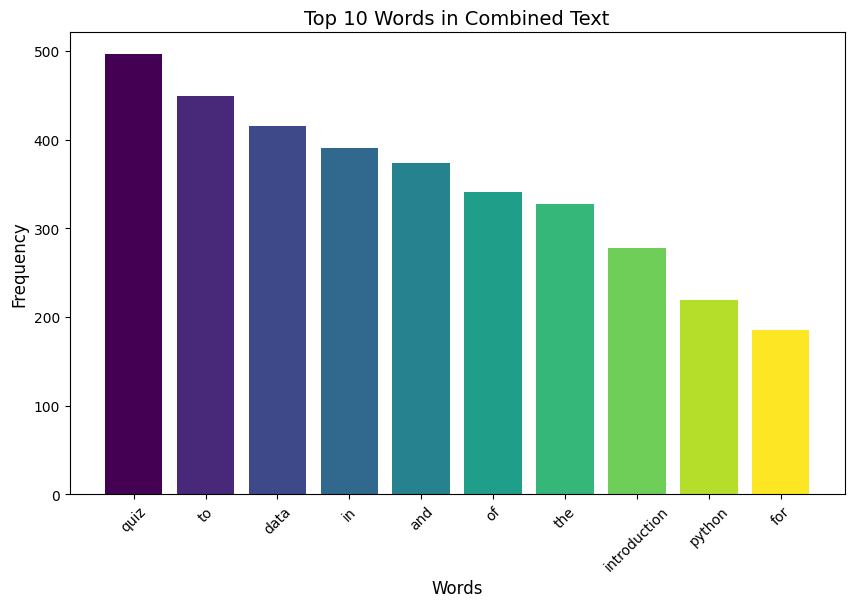

In [23]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

# Function to plot the top N words with different colors
def plot_top_n_words(text, n=10):
    words = text.split()
    word_counts = Counter(words)
    common_words = word_counts.most_common(n)
    words, counts = zip(*common_words)

    # Generate a list of colors using a colormap
    colors = plt.cm.viridis(np.linspace(0, 1, n))  # Using the Viridis colormap

    plt.figure(figsize=(10, 6))
    plt.bar(words, counts, color=colors)  # Apply different colors for each bar
    plt.xlabel('Words', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title(f'Top {n} Words in Combined Text', fontsize=14)
    plt.xticks(rotation=45)
    plt.show()

# Example usage
plot_top_n_words(text_combined, n=10)


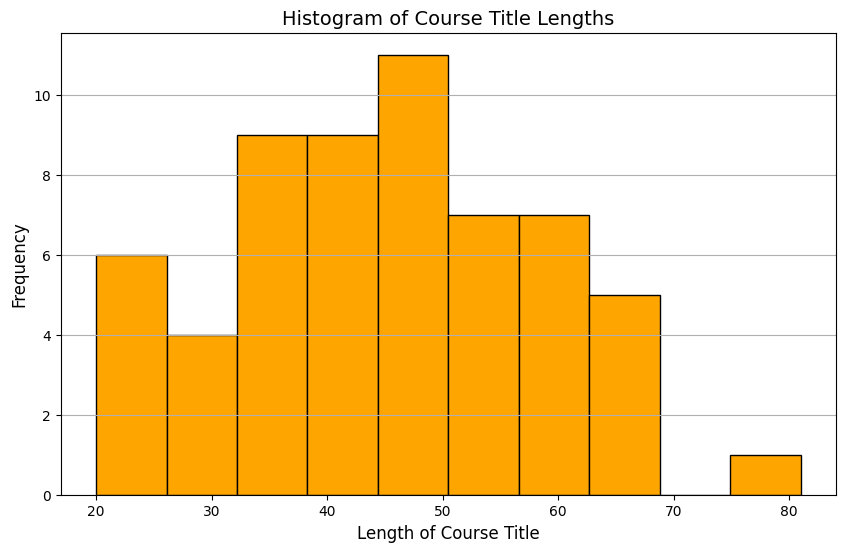

In [21]:
#  Histogram of Course Title Lengths
df['Title Length'] = df['Course Title Clean'].apply(len)

plt.figure(figsize=(10, 6))
plt.hist(df['Title Length'], bins=10, color='orange', edgecolor='black')
plt.xlabel('Length of Course Title', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Histogram of Course Title Lengths', fontsize=14)
plt.grid(axis='y')
plt.show()

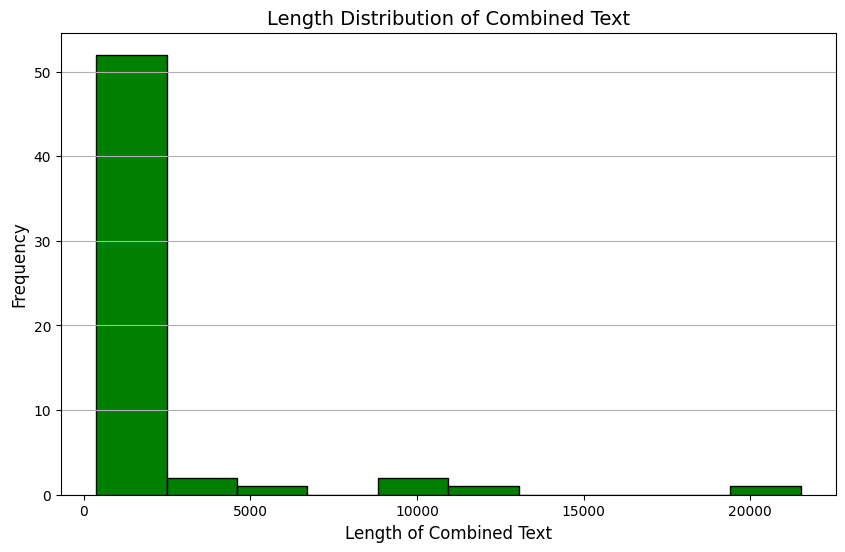

In [22]:
#  Length Distribution of Combined Text
df['Combined Text Length'] = df['Combined Text'].apply(len)

plt.figure(figsize=(10, 6))
plt.hist(df['Combined Text Length'], bins=10, color='green', edgecolor='black')
plt.xlabel('Length of Combined Text', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Length Distribution of Combined Text', fontsize=14)
plt.grid(axis='y')
plt.show()

<h3>After aplying the nlp methods dataset passing into Tfidfvectorizer</h3>

In [158]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Initialize the TF-IDF Vectorizer with stop words removal
vectorizer = TfidfVectorizer(stop_words='english')

# Fit and transform the combined text to get embeddings
embeddings = vectorizer.fit_transform(df['Combined Text'])
embeddings

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 4732 stored elements and shape (59, 1679)>

<h3>Applying the cosine_similarities </h3>

In [159]:
# Function to search courses based on a query
def search_courses(query, embeddings, df, vectorizer):
    # Transform the user query to the same embedding space
    query_embedding = vectorizer.transform([query]).toarray()  # Convert to dense NumPy array
    
    # Check the shape of the embeddings
    print("Query embedding shape:", query_embedding.shape)
    print("Embeddings shape:", embeddings.shape)
    
    # Calculate cosine similarity between the query embedding and course embeddings
    cosine_similarities = np.dot(embeddings, query_embedding.T).flatten()

    # Check for valid cosine similarities
    if not np.any(cosine_similarities):
        return pd.DataFrame()  # Return empty DataFrame if no valid similarities

    # Get the indices of the top 5 most similar courses
    top_indices = np.argsort(cosine_similarities)[-5:][::-1]
    
    # Return the top courses
    return df.iloc[top_indices]


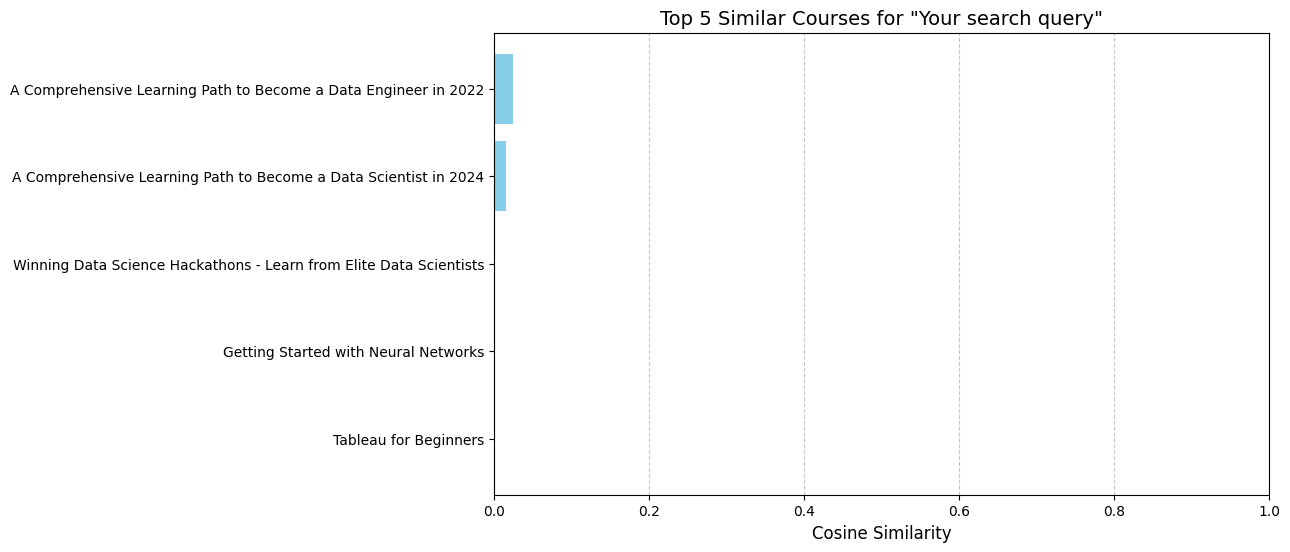

In [217]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Function to search courses based on a query
def search_courses(query, embeddings, df, vectorizer):
    # Transform the user query to the same embedding space
    query_embedding = vectorizer.transform([query]).toarray()  # Convert to dense NumPy array
    
    # Calculate cosine similarity between the query embedding and course embeddings
    cosine_similarities = np.dot(embeddings, query_embedding.T).flatten()
    
    # Check for valid cosine similarities
    if not np.any(cosine_similarities):
        return pd.DataFrame()  # Return empty DataFrame if no valid similarities

    # Get the indices of the top 5 most similar courses
    top_indices = np.argsort(cosine_similarities)[-5:][::-1]
    
    # Extract top course details and their similarity scores
    top_courses = df.iloc[top_indices]
    top_scores = cosine_similarities[top_indices]

    # Visualization of the results
    plt.figure(figsize=(10, 6))
    plt.barh(top_courses['Course Title'], top_scores, color='skyblue')
    plt.xlabel('Cosine Similarity', fontsize=12)
    plt.title(f'Top 5 Similar Courses for "{query}"', fontsize=14)
    plt.xlim(0, 1)  # Cosine similarity ranges from 0 to 1
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest score on top
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

    return top_courses

# Example usage (Make sure to call this within the context where df, vectorizer, and embeddings are defined)
results = search_courses("Your search query", embeddings, df, vectorizer)


In [198]:
%matplotlib inline

<h1>>>>>>Applying the clustering techinques for best suggestions<<<<</h1>

<h3>Kmeans clustering model</h3>

In [164]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import os

# Initialize an empty list to store the within-cluster sum of squares (WCSS)
wcss = []

# Iterate over a range of cluster numbers (1 to 10)
for i in range(1, 11):
    # Create a KMeans instance with the current number of clusters
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    
    # Fit the KMeans model to the embeddings (or the feature data)
    kmeans.fit(embeddings)
    
    # Append the WCSS (sum of squared distances of samples to their closest cluster center) to the list
    wcss.append(kmeans.inertia_)

# Plot the WCSS values against the number of clusters to visualize the Elbow Method
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--', color='b')
plt.xlabel('Number of clusters (k)', fontsize=12)
plt.ylabel('Within-cluster Sum of Squares (WCSS)', fontsize=12)
plt.title('Elbow Method to Determine Optimal Clusters', fontsize=14)
plt.grid(True)

# Save the plot as an image file
plt.savefig('elbow_method_plot.png')  # Save to a PNG file
plt.close()  # Close the plot to free up memory

# Print the location of the saved image
print("Plot saved as 'elbow_method_plot.png' in", os.getcwd())


Plot saved as 'elbow_method_plot.png' in C:\Users\Dell


For n_clusters = 2, silhouette score = 0.02306366726304818
For n_clusters = 3, silhouette score = 0.021783513107135437
For n_clusters = 4, silhouette score = 0.020961747562469622
For n_clusters = 5, silhouette score = 0.01718444712541201
For n_clusters = 6, silhouette score = 0.025193217974103285
For n_clusters = 7, silhouette score = 0.030760917936306836
For n_clusters = 8, silhouette score = 0.042924769595378276
For n_clusters = 9, silhouette score = 0.04851742982142443
For n_clusters = 10, silhouette score = 0.038952493308117155


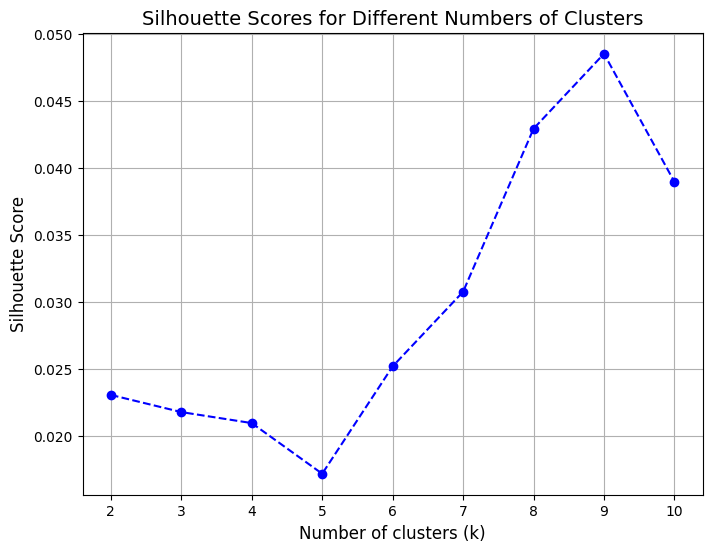

In [199]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Define the range of clusters you want to evaluate
cluster_range = range(2, 11)  # From 2 to 10 clusters
silhouette_scores = []

# Iterate over the cluster range
for num_clusters in cluster_range:
    # Create and fit the KMeans model
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(embeddings)
    
    # Get the cluster labels
    cluster_labels = kmeans.labels_
    
    # Calculate the silhouette score
    silhouette_avg = silhouette_score(embeddings, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    
    # Print the silhouette score in the desired format
    print(f"For n_clusters = {num_clusters}, silhouette score = {silhouette_avg}")

# Optionally, you can plot the silhouette scores for better visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(cluster_range, silhouette_scores, marker='o', linestyle='--', color='b')
plt.xlabel('Number of clusters (k)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Silhouette Scores for Different Numbers of Clusters', fontsize=14)
plt.grid(True)

# Save the plot as an image
plt.savefig('silhouette_scores.png', bbox_inches='tight')

# Show the plot
plt.show()  # Display the plot in the notebook



In [203]:
from sklearn.cluster import KMeans

# Perform K-Means Clustering
num_clusters = 8 # You can adjust this number based on your dataset
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(embeddings)
cluster_labels = kmeans.labels_

# Assign cluster labels to the DataFrame
df['Cluster'] = cluster_labels


In [204]:
df['Cluster'].head()

0    0
1    4
2    4
3    2
4    0
Name: Cluster, dtype: int32

In [205]:
# Calculate the distance of each course to its assigned cluster centroid
distances = kmeans.transform(embeddings)  # Shape: (n_samples, n_clusters)
# Extract the distance to the assigned cluster for each course
df['Cluster Distance'] = distances[np.arange(len(cluster_labels)), cluster_labels]
df['Cluster Distance'].tail()

54    0.895574
55    0.827143
56    0.803485
57    0.920920
58    0.853253
Name: Cluster Distance, dtype: float64

In [206]:
from sklearn.metrics import silhouette_score

# Calculate the silhouette score for the current cluster_labels
silhouette_avg = silhouette_score(embeddings, cluster_labels)

# Print the silhouette score in the desired format
n_clusters = len(set(cluster_labels))  # Number of clusters
print(f"For n_clusters = {n_clusters}, silhouette score = {silhouette_avg}")


For n_clusters = 8, silhouette score = 0.042924769595378276


<h3>kmeans given the silhouette score = 0.042924769595378276 moderate score </h3>

<h1>>>>>DBSCAN Model<<<<</h1>

In [207]:
#ploting was display the best in line 
%matplotlib inline

For n_clusters = 2, silhouette score (Hierarchical) = 0.0033004669495162063
For n_clusters = 3, silhouette score (Hierarchical) = 0.012875098815974215
For n_clusters = 4, silhouette score (Hierarchical) = 0.021014780521318957
For n_clusters = 5, silhouette score (Hierarchical) = 0.02622171021036372
For n_clusters = 6, silhouette score (Hierarchical) = 0.030696427521736347
For n_clusters = 7, silhouette score (Hierarchical) = 0.04219571966610891
For n_clusters = 8, silhouette score (Hierarchical) = 0.04767367076758198
For n_clusters = 9, silhouette score (Hierarchical) = 0.055417240777447904
For n_clusters = 10, silhouette score (Hierarchical) = 0.059706316431947216


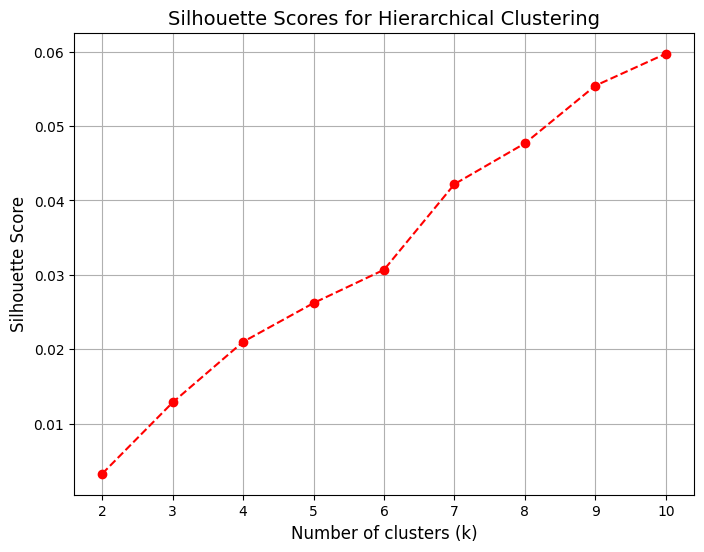

In [208]:
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Enable inline plotting
%matplotlib inline

# Function to evaluate hierarchical clustering
def evaluate_hierarchical_clustering(embeddings, cluster_range):
    # Convert embeddings to dense format if it's sparse
    if hasattr(embeddings, 'toarray'):
        embeddings = embeddings.toarray()

    silhouette_scores_hierarchical = []
    
    for num_clusters in cluster_range:
        # Create and fit the AgglomerativeClustering model
        hierarchical = AgglomerativeClustering(n_clusters=num_clusters)
        cluster_labels = hierarchical.fit_predict(embeddings)
        
        # Calculate the silhouette score
        silhouette_avg = silhouette_score(embeddings, cluster_labels)
        silhouette_scores_hierarchical.append(silhouette_avg)
        
        # Print the silhouette score in the desired format
        print(f"For n_clusters = {num_clusters}, silhouette score (Hierarchical) = {silhouette_avg}")

    return silhouette_scores_hierarchical

# Call the function with your embeddings
cluster_range = range(2, 11)
silhouette_scores = evaluate_hierarchical_clustering(embeddings, cluster_range)

# Plotting the silhouette scores for Hierarchical Clustering
plt.figure(figsize=(8, 6))
plt.plot(cluster_range, silhouette_scores, marker='o', linestyle='--', color='r')
plt.xlabel('Number of clusters (k)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Silhouette Scores for Hierarchical Clustering', fontsize=14)
plt.grid(True)

# Save the plot as an image
plt.savefig('silhouette_scores.png', bbox_inches='tight')

# Show the plot
plt.show()  # Display the plot in the notebook


For n_clusters = 2, silhouette score (Hierarchical) = 0.6470918291096847
For n_clusters = 3, silhouette score (Hierarchical) = 0.46554981807996015
For n_clusters = 4, silhouette score (Hierarchical) = 0.4762364671817496
For n_clusters = 5, silhouette score (Hierarchical) = 0.5186355122444514
For n_clusters = 6, silhouette score (Hierarchical) = 0.47909165854654623
For n_clusters = 7, silhouette score (Hierarchical) = 0.40263872310341564
For n_clusters = 8, silhouette score (Hierarchical) = 0.43731010588211844
For n_clusters = 9, silhouette score (Hierarchical) = 0.45722436124512894
For n_clusters = 10, silhouette score (Hierarchical) = 0.4643933678890538


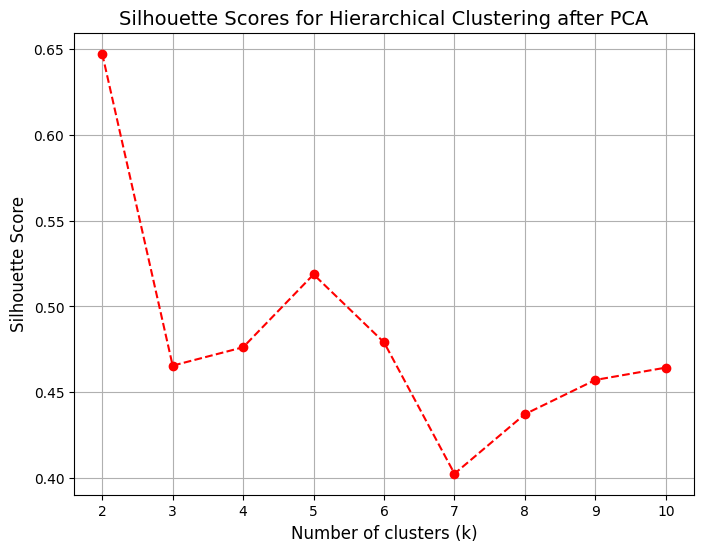

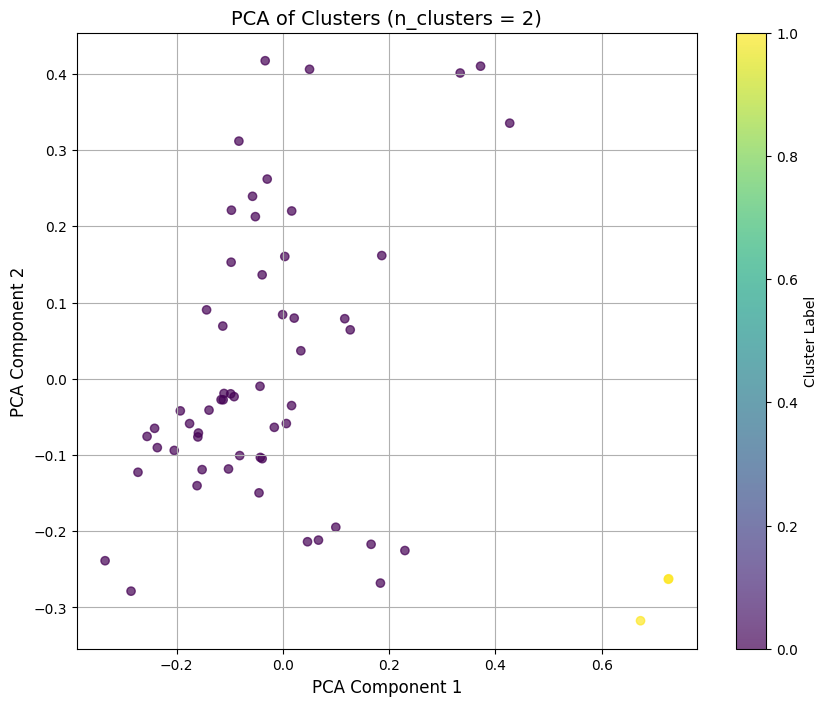

In [209]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import issparse

# Check if embeddings is a sparse matrix
if issparse(embeddings):
    embeddings = embeddings.toarray()  # Convert sparse to dense

# Perform PCA to reduce dimensionality for clustering
pca = PCA(n_components=2)  # Reduce to 2 dimensions
embeddings_reduced = pca.fit_transform(embeddings)

# Define the range of clusters you want to evaluate for hierarchical clustering
cluster_range = range(2, 11)  # From 2 to 10 clusters
silhouette_scores_hierarchical = []

# Iterate over the cluster range after PCA
for num_clusters in cluster_range:
    # Create and fit the AgglomerativeClustering model
    hierarchical = AgglomerativeClustering(n_clusters=num_clusters)
    cluster_labels = hierarchical.fit_predict(embeddings_reduced)
    
    # Calculate the silhouette score
    silhouette_avg = silhouette_score(embeddings_reduced, cluster_labels)
    silhouette_scores_hierarchical.append(silhouette_avg)
    
    # Print the silhouette score in the desired format
    print(f"For n_clusters = {num_clusters}, silhouette score (Hierarchical) = {silhouette_avg}")

# Plotting the silhouette scores for Hierarchical Clustering
plt.figure(figsize=(8, 6))
plt.plot(cluster_range, silhouette_scores_hierarchical, marker='o', linestyle='--', color='r')
plt.xlabel('Number of clusters (k)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Silhouette Scores for Hierarchical Clustering after PCA', fontsize=14)
plt.grid(True)
plt.show()

# Final clustering using the best number of clusters (based on silhouette score)
best_num_clusters = cluster_range[np.argmax(silhouette_scores_hierarchical)]  # Choose the best number of clusters
hierarchical_final = AgglomerativeClustering(n_clusters=best_num_clusters)
cluster_labels_final = hierarchical_final.fit_predict(embeddings_reduced)

# Plotting PCA results with the final cluster labels
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_reduced[:, 0], embeddings_reduced[:, 1], c=cluster_labels_final, cmap='viridis', alpha=0.7)
plt.title(f'PCA of Clusters (n_clusters = {best_num_clusters})', fontsize=14)
plt.xlabel('PCA Component 1', fontsize=12)
plt.ylabel('PCA Component 2', fontsize=12)
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.show()


For n_clusters = 2, silhouette score (Hierarchical) = 0.6470140095139285


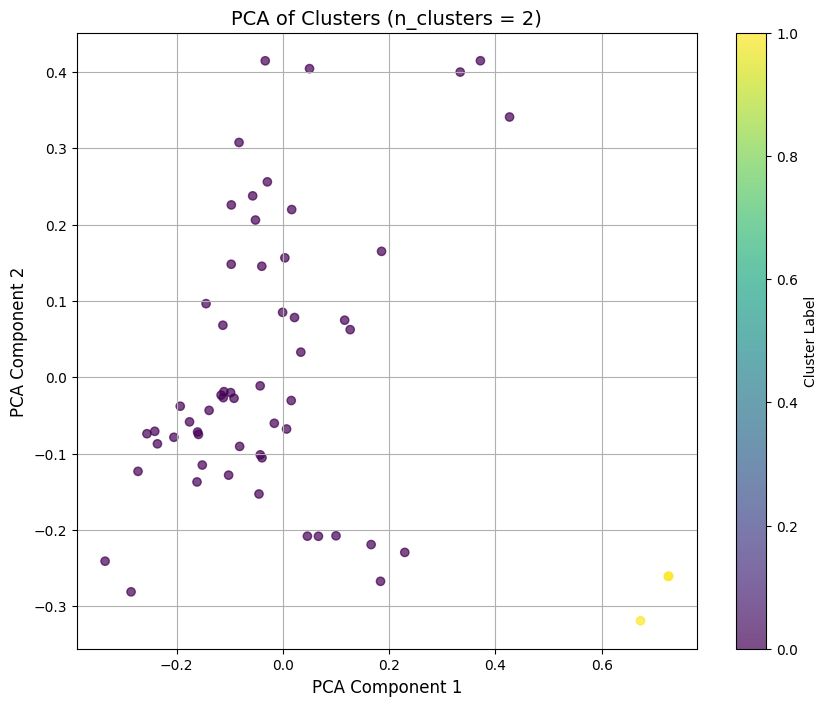

In [210]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import issparse

# Check if embeddings is a sparse matrix
if issparse(embeddings):
    embeddings = embeddings.toarray()  # Convert sparse to dense

# Perform PCA to reduce dimensionality for clustering
pca = PCA(n_components=2)  # Reduce to 2 dimensions
embeddings_reduced = pca.fit_transform(embeddings)

# Set the number of clusters to 2
n_clusters = 2

# Create and fit the AgglomerativeClustering model
hierarchical = AgglomerativeClustering(n_clusters=n_clusters)
cluster_labels_final_one = hierarchical.fit_predict(embeddings_reduced)

# Calculate the silhouette score for 3 clusters
silhouette_avg = silhouette_score(embeddings_reduced, cluster_labels_final_one)
print(f"For n_clusters = {n_clusters}, silhouette score (Hierarchical) = {silhouette_avg}")

# Plotting PCA results with the final cluster labels
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_reduced[:, 0], embeddings_reduced[:, 1], c=cluster_labels_final_one, cmap='viridis', alpha=0.7)  # Use cluster_labels_final_one
plt.title(f'PCA of Clusters (n_clusters = {n_clusters})', fontsize=14)
plt.xlabel('PCA Component 1', fontsize=12)
plt.ylabel('PCA Component 2', fontsize=12)
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.show()


<h3>Dbscan is given the good score after aplying the pca For n_clusters = 2, silhouette score (Hierarchical) = 0.6470140095139285 </h3>

<h1>>>>>Save the model in pickel<<<<</h1>

In [186]:
import pickle

# Define the data you want to save in the pickle file
data_to_save = {
    'vectorizer': vectorizer,
    'embeddings': embeddings,
    'cluster_labels': cluster_labels_final_one,
    'df': df  # If you want to save the original DataFrame as well
}

# Specify the filename
filename = 'course_finally_model(2).pkl'

# Save the data to a pickle file
with open(filename, 'wb') as file:
    pickle.dump(data_to_save, file)

print(f"Model and data saved to {filename}.")


Model and data saved to course_finally_model(2).pkl.


In [ ]:
# Load the data from the pickle file
with open(filename, 'rb') as file:
    loaded_data = pickle.load(file)

# Access the contents
loaded_vectorizer = loaded_data['vectorizer']
loaded_embeddings = loaded_data['embeddings']
loaded_cluster_labels = loaded_data['cluster_labels']
loaded_df = loaded_data['df']  # If you saved the DataFrame

print("Data loaded successfully.")


<h1>>>>Gradio deployment<<<</h1>

In [212]:
import gradio as gr
import pandas as pd
import pickle
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

# Load the saved DataFrame and embeddings from the pickle file
def load_data():
    with open('course_finally_model(2).pkl', 'rb') as f:
        data = pickle.load(f)
    
    # Extract data from the loaded dictionary
    df = data['df']
    vectorizer = data['vectorizer']
    embeddings = np.array(data['embeddings'])  # Ensure this is a NumPy array
    
    return df, vectorizer, embeddings

# Function to search courses based on a query
def search_courses(query, embeddings, df, vectorizer):
    # Transform the user query to the same embedding space
    query_embedding = vectorizer.transform([query]).toarray()  # Convert to dense NumPy array
    
    # Calculate cosine similarity between the query embedding and course embeddings
    cosine_similarities = np.dot(embeddings, query_embedding.T).flatten()
    
    # Check for valid cosine similarities
    if not np.any(cosine_similarities):
        return pd.DataFrame()  # Return empty DataFrame if no valid similarities

    # Get the indices of the top 5 most similar courses
    top_indices = np.argsort(cosine_similarities)[-5:][::-1]
    
    # Return the top courses
    return df.iloc[top_indices]

# Load data and embeddings
df, vectorizer, embeddings = load_data()

# Gradio search function
def gradio_search(query):
    results = search_courses(query, embeddings, df, vectorizer)
    if results.empty:
        return []  # Return an empty list if no results found
    return results[['Course Title', 'Course Description', 'Course Curriculum', 'Course URL']].to_dict(orient='records')

# Create the Gradio interface
iface = gr.Interface(
    fn=gradio_search,
    inputs="text",
    outputs="json",
    title="Course Search Tool",
    description="Search for courses using keywords."
)

# Launch the Gradio app
iface.launch()


* Running on local URL:  http://127.0.0.1:7865

To create a public link, set `share=True` in `launch()`.


In [ ]:
<